# Merge of Epithelial (binarised marker) vs Fibroblast and run spatial analysis

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import os, sys

other_dir_path = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(other_dir_path)

print(other_dir_path)
import IMCprocess.spatial_analysis.spatial_analysis as sa
import IMCprocess.spatial_analysis.combi_enrich as ce
import IMCprocess.utils.utils as ut

# I have to use custom Img_anndata code
import Img_anndata as utan

/Users/pattama/Desktop/UiB/cancer/git_repo/IMCprocess


## Import mask and level1 annotated object and create epithelial object

In [2]:
data_dir = '/Users/pattama/Desktop/UiB/cancer/example_share_code/share_with_vladan/mask_analysis_full_pipeline/example_data/'
input_mask = data_dir + 'Patient2_001.tiff'
output_dir = 'output'
level1_file = data_dir + '00hanna_adata_totalNB_obj_Level1.pkl'
myimg_id = 'R2_001'
Img_obj_level1 = ut.read_pickle_obj(level1_file)
# Get adata level1 for img_id R2_001
Img_level1_R2_001 = ut.filter_adata_obs(Img_obj_level1.adata_dict['level1'],
                                        'img_id', 
                                        [myimg_id])
# Get Epi adata
Epi_adata = ut.filter_adata_obs(Img_level1_R2_001,
                                'level1_annotated',
                                ['Ep'])

## Label cells for neg or pos cells from chosen threshold and add to obs in object

In [3]:
def binary_df(df, threshold):
    df_binary = df.applymap(lambda x: 'Ep_pos' if x >= threshold else 'Ep_neg')
    df_binary.columns = ['level2_'+col + '_'+ str(round(threshold,2)) for col in df.columns]
    return(df_binary)

In [4]:
# User provide input marker column and 
# selected threshold for each marker 
# (User can choose more than one threshold 
# for the same marker to compare)
marker_threshold_dict = {'168Er_Ki67': [0.2],
                         '143Nd_Vimentin': [0.2, 0.3],
                         '169Tm_CD24': [0.4]
}

In [5]:
binary_df_ls = []
for marker, threshold_list in marker_threshold_dict.items():
    marker_bi_ls = [binary_df(Epi_adata.to_df()[[marker]], threshold) 
                    for threshold in threshold_list]
    marker_bi_df = pd.concat(marker_bi_ls, axis=1)
    binary_df_ls.append(marker_bi_df)
binary_all_marker = pd.concat(binary_df_ls, axis=1)

In [6]:
binary_all_marker.head()

level2_168Er_Ki67_0.2 level2_143Nd_Vimentin_0.2  \
Cell_id                                                   
14301_3                Ep_pos                    Ep_pos   
14304_3                Ep_pos                    Ep_pos   
14305_3                Ep_neg                    Ep_pos   
14307_3                Ep_neg                    Ep_pos   
14308_3                Ep_neg                    Ep_neg   

        level2_143Nd_Vimentin_0.3 level2_169Tm_CD24_0.4  
Cell_id                                                  
14301_3                    Ep_pos                Ep_pos  
14304_3                    Ep_pos                Ep_pos  
14305_3                    Ep_pos                Ep_neg  
14307_3                    Ep_pos                Ep_pos  
14308_3                    Ep_neg                Ep_pos

In [7]:
# add binary df in adata obs
Epi_adata.obs = pd.concat([Epi_adata.obs, binary_all_marker], axis=1)

In [8]:
Epi_adata.obs

img_id PhenoGraph_clusters level1_annotated level2_168Er_Ki67_0.2  \
Cell_id                                                                      
14301_3  R2_001                  25               Ep                Ep_pos   
14304_3  R2_001                  43               Ep                Ep_pos   
14305_3  R2_001                   9               Ep                Ep_neg   
14307_3  R2_001                   9               Ep                Ep_neg   
14308_3  R2_001                  16               Ep                Ep_neg   
...         ...                 ...              ...                   ...   
21466_3  R2_001                   1               Ep                Ep_pos   
21467_3  R2_001                   1               Ep                Ep_pos   
21468_3  R2_001                  13               Ep                Ep_neg   
21476_3  R2_001                   2               Ep                Ep_neg   
21477_3  R2_001                  15               Ep                Ep_pos   

        level2_143Nd_Vimentin_0.2 level2_143Nd_Vimentin_0.3  \
Cell_id                                                       
14301_3                    Ep_pos                    Ep_pos   
14304_3                    Ep_pos                    Ep_pos   
14305_3                    Ep_pos                    Ep_pos   
14307_3                    Ep_pos                    Ep_pos   
14308_3                    Ep_neg                    Ep_neg   
...                           ...                       ...   
21466_3                    Ep_pos                    Ep_neg   
21467_3                    Ep_pos                    Ep_neg   
21468_3                    Ep_pos                    Ep_pos   
21476_3                    Ep_pos                    Ep_pos   
21477_3                    Ep_neg                    Ep_neg   

        level2_169Tm_CD24_0.4  
Cell_id                        
14301_3                Ep_pos  
14304_3                Ep_pos  
14305_3                Ep_neg  
14307_3                Ep_pos  
14308_3                Ep_pos  
...                       ...  
21466_3                Ep_pos  
21467_3                Ep_neg  
21468_3                Ep_neg  
21476_3                Ep_neg  
21477_3                Ep_pos  

[3463 rows x 7 columns]

## Merge Epi and Fibro adata

In [9]:
# import Fibro adata
Fibro_obj = ut.read_pickle_obj(data_dir + '02hanna_adata_totalNB_obj_Level2.pkl')
# Get adata Fibro only for img_id R2_001
Fibro_adata = ut.filter_adata_obs(Fibro_obj.adata_dict['Fibro_level2'],
                                  'img_id', 
                                  [myimg_id])
# add Fibro in front of level2 annotation
Fibro_adata.obs['Fibro_level2_annotated'] = Fibro_adata.obs[
    'Fibro_level2_annotated'].apply(lambda x: 'Fibro_' + x)

/var/folders/_d/_v_3rt457zj_nkkxtccyqtth0000gn/T/ipykernel_13836/3300431072.py:8: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  Fibro_adata.obs['Fibro_level2_annotated'] = Fibro_adata.obs[


In [10]:
Fibro_adata.obs.head()

img_id PhenoGraph_clusters level1_annotated  \
Cell_id                                                
14302_3  R2_001                  11            Fibro   
14303_3  R2_001                  24            Fibro   
14306_3  R2_001                  15            Fibro   
14309_3  R2_001                  13            Fibro   
14310_3  R2_001                  20            Fibro   

                         Fibro_level2_annotated  
Cell_id                                          
14302_3  Fibro_aSMA+_FAPlow_PDGFRalow_PDGFRblow  
14303_3         Fibro_aSMA+_PDGFRalow_PDGFRblow  
14306_3  Fibro_aSMAlow_FAP+_PDGFRalow_PDGFRblow  
14309_3  Fibro_aSMA+_FAPlow_PDGFRalow_PDGFRblow  
14310_3    Fibro_aSMA+_FAP+_PDGFRalow_PDGFRblow

168Er_Ki67


100%|██████████| 1000/1000 [00:05<00:00, 179.05/s]


level2_168Er_Ki67_0.2
143Nd_Vimentin


100%|██████████| 1000/1000 [00:05<00:00, 185.15/s]


level2_143Nd_Vimentin_0.2


100%|██████████| 1000/1000 [00:05<00:00, 189.23/s]


level2_143Nd_Vimentin_0.3
169Tm_CD24


100%|██████████| 1000/1000 [00:05<00:00, 189.27/s]


level2_169Tm_CD24_0.4


<Figure size 800x500 with 0 Axes>

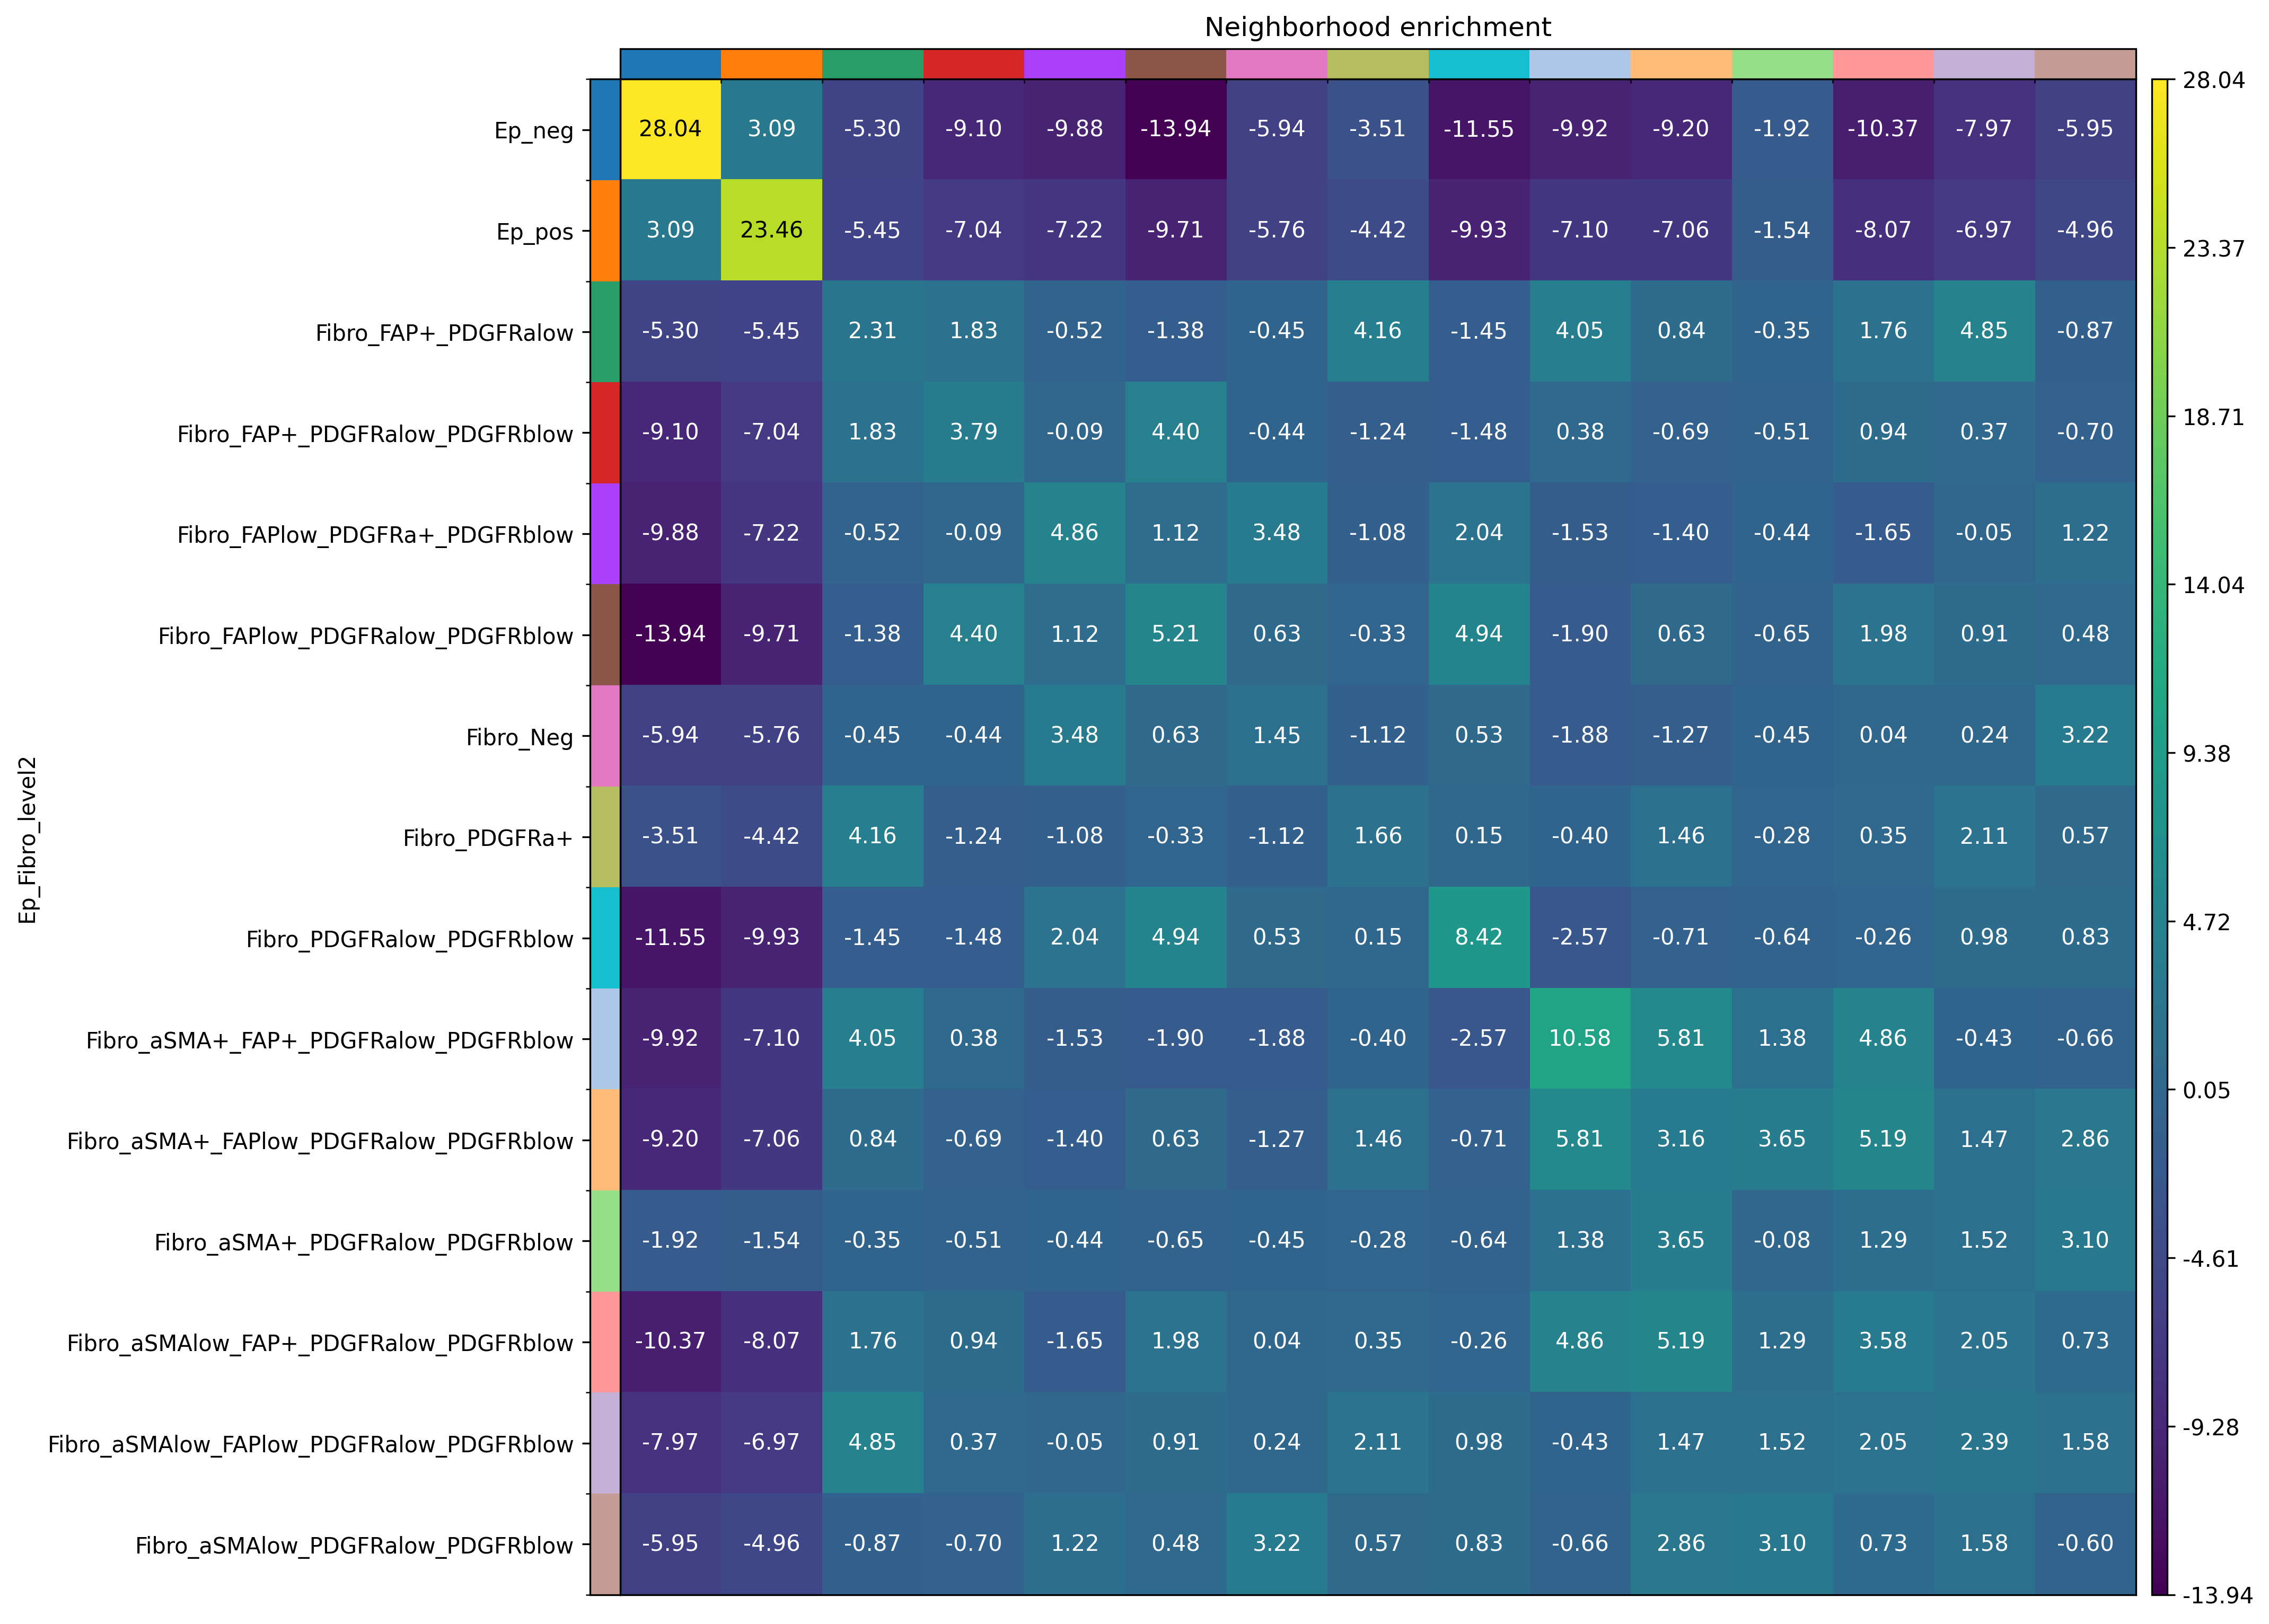

<Figure size 800x500 with 0 Axes>

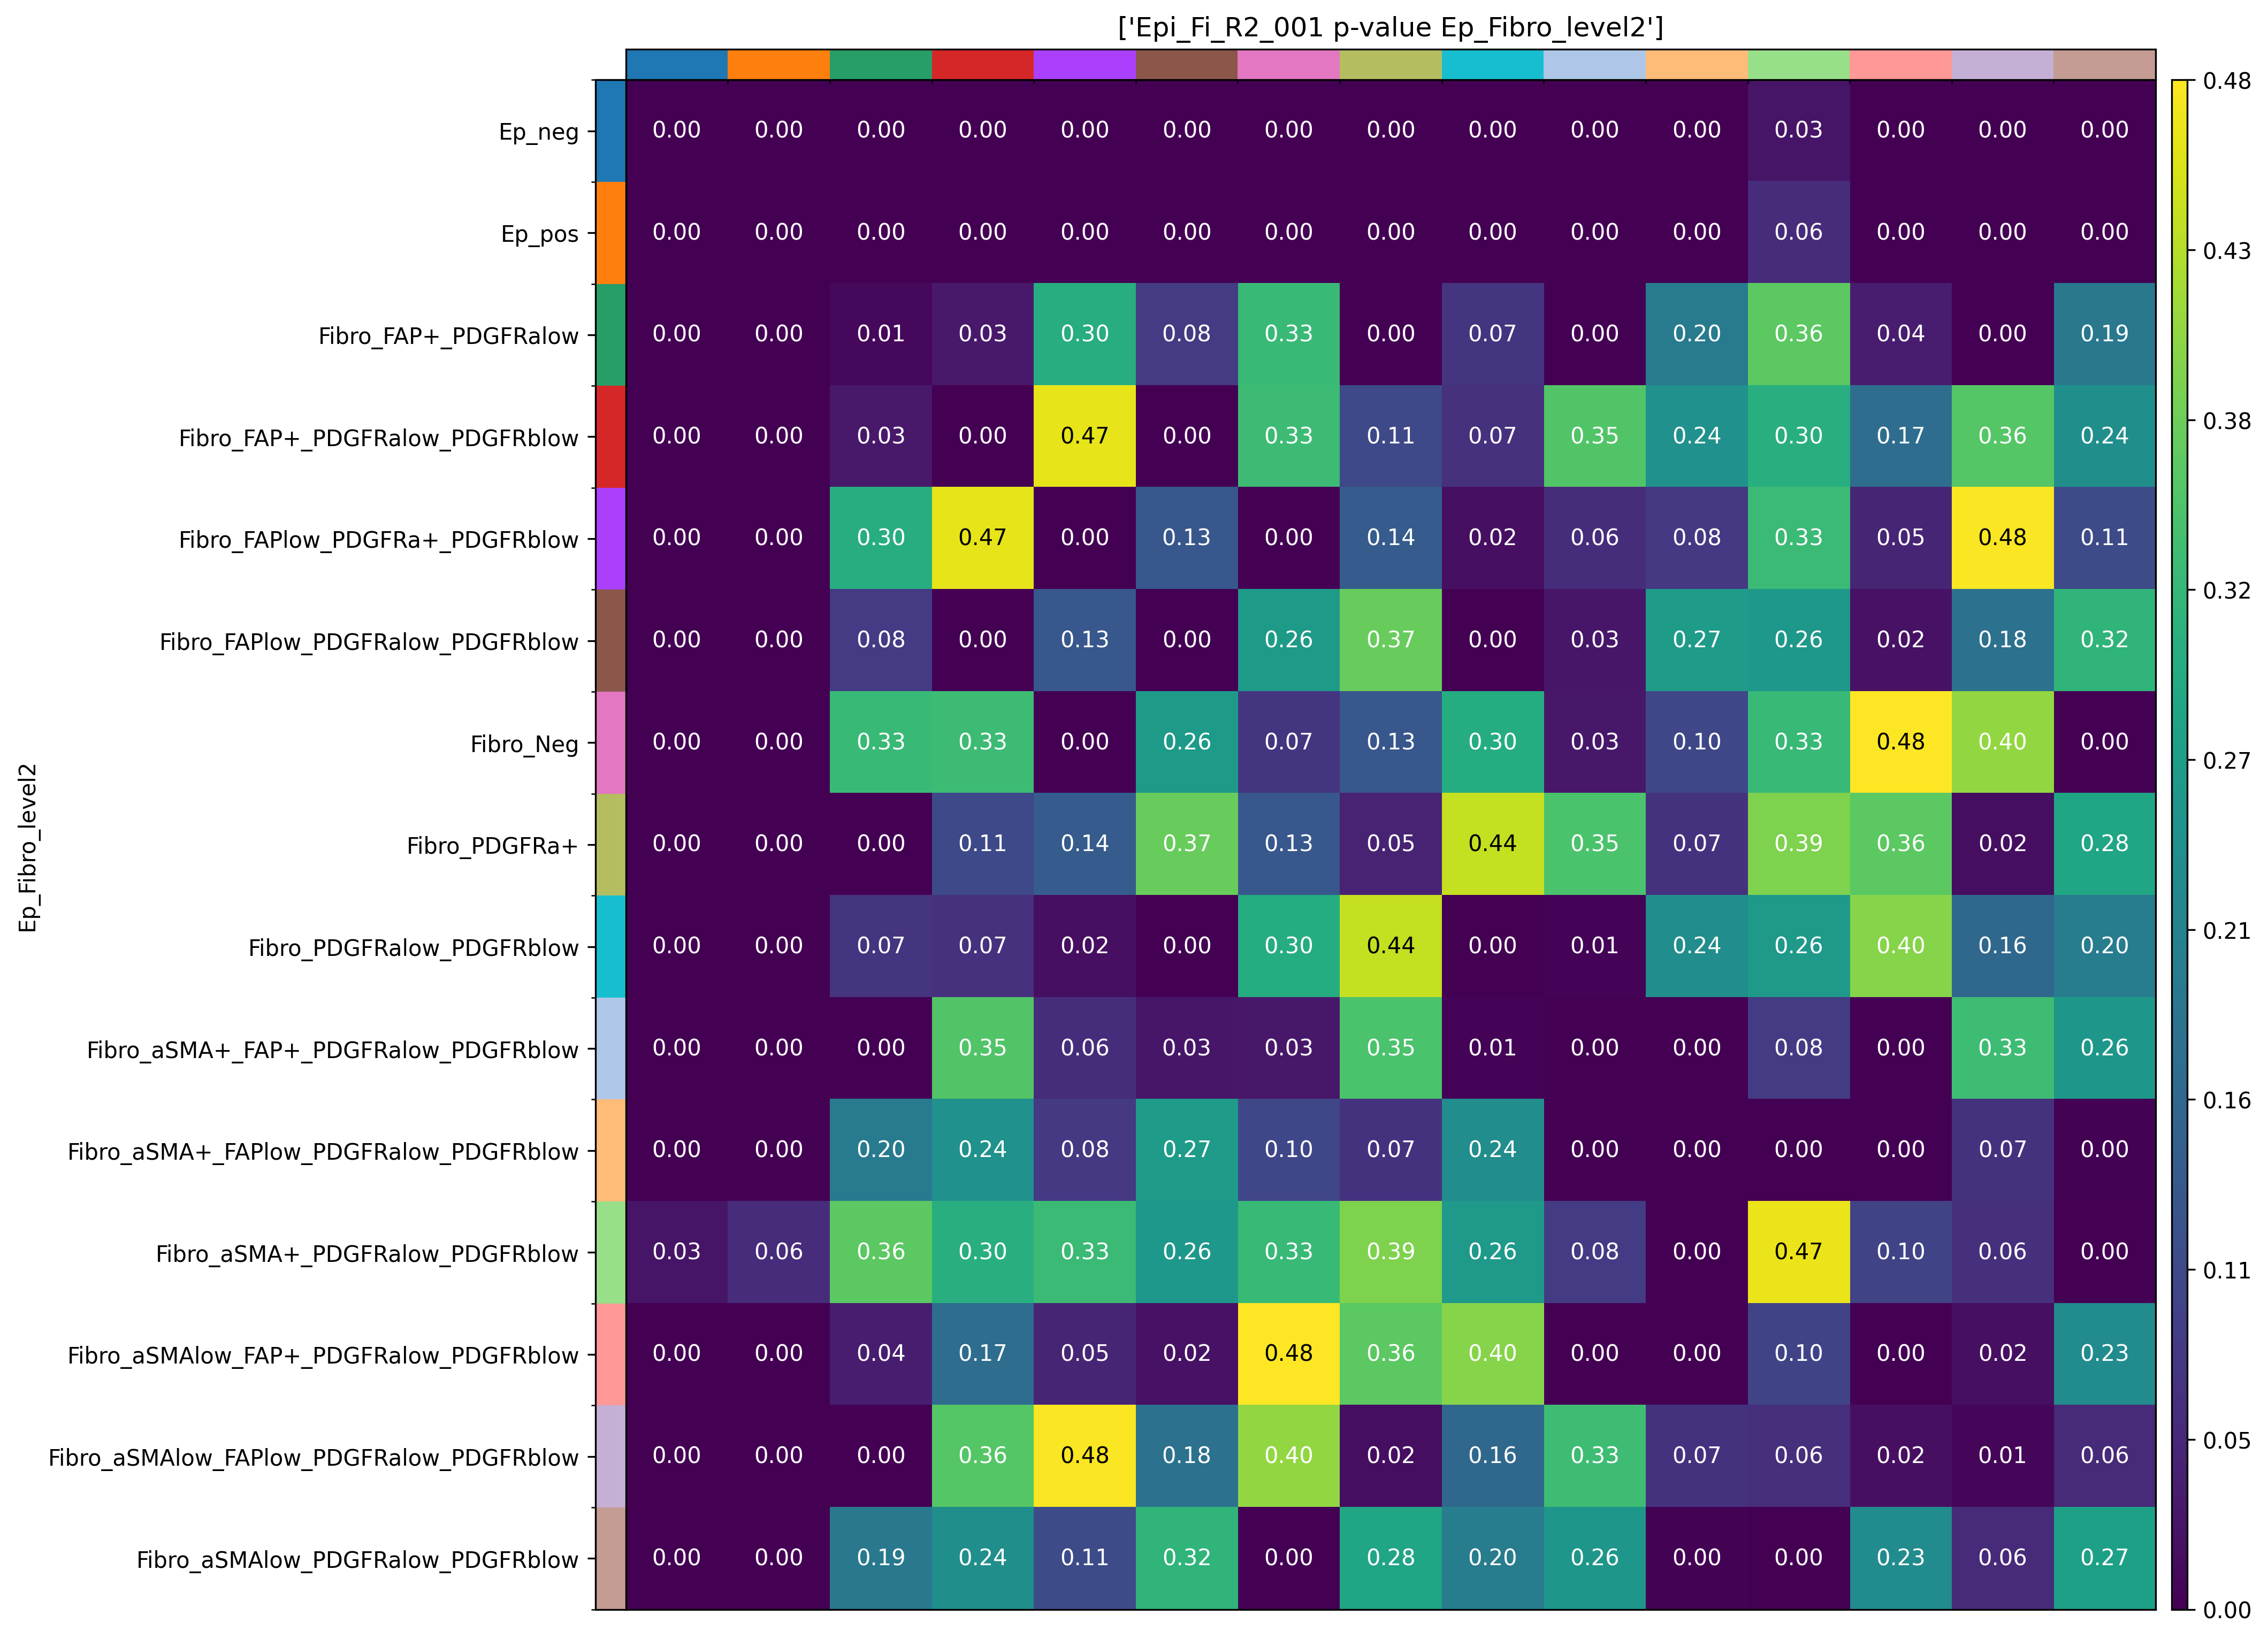

<Figure size 800x500 with 0 Axes>

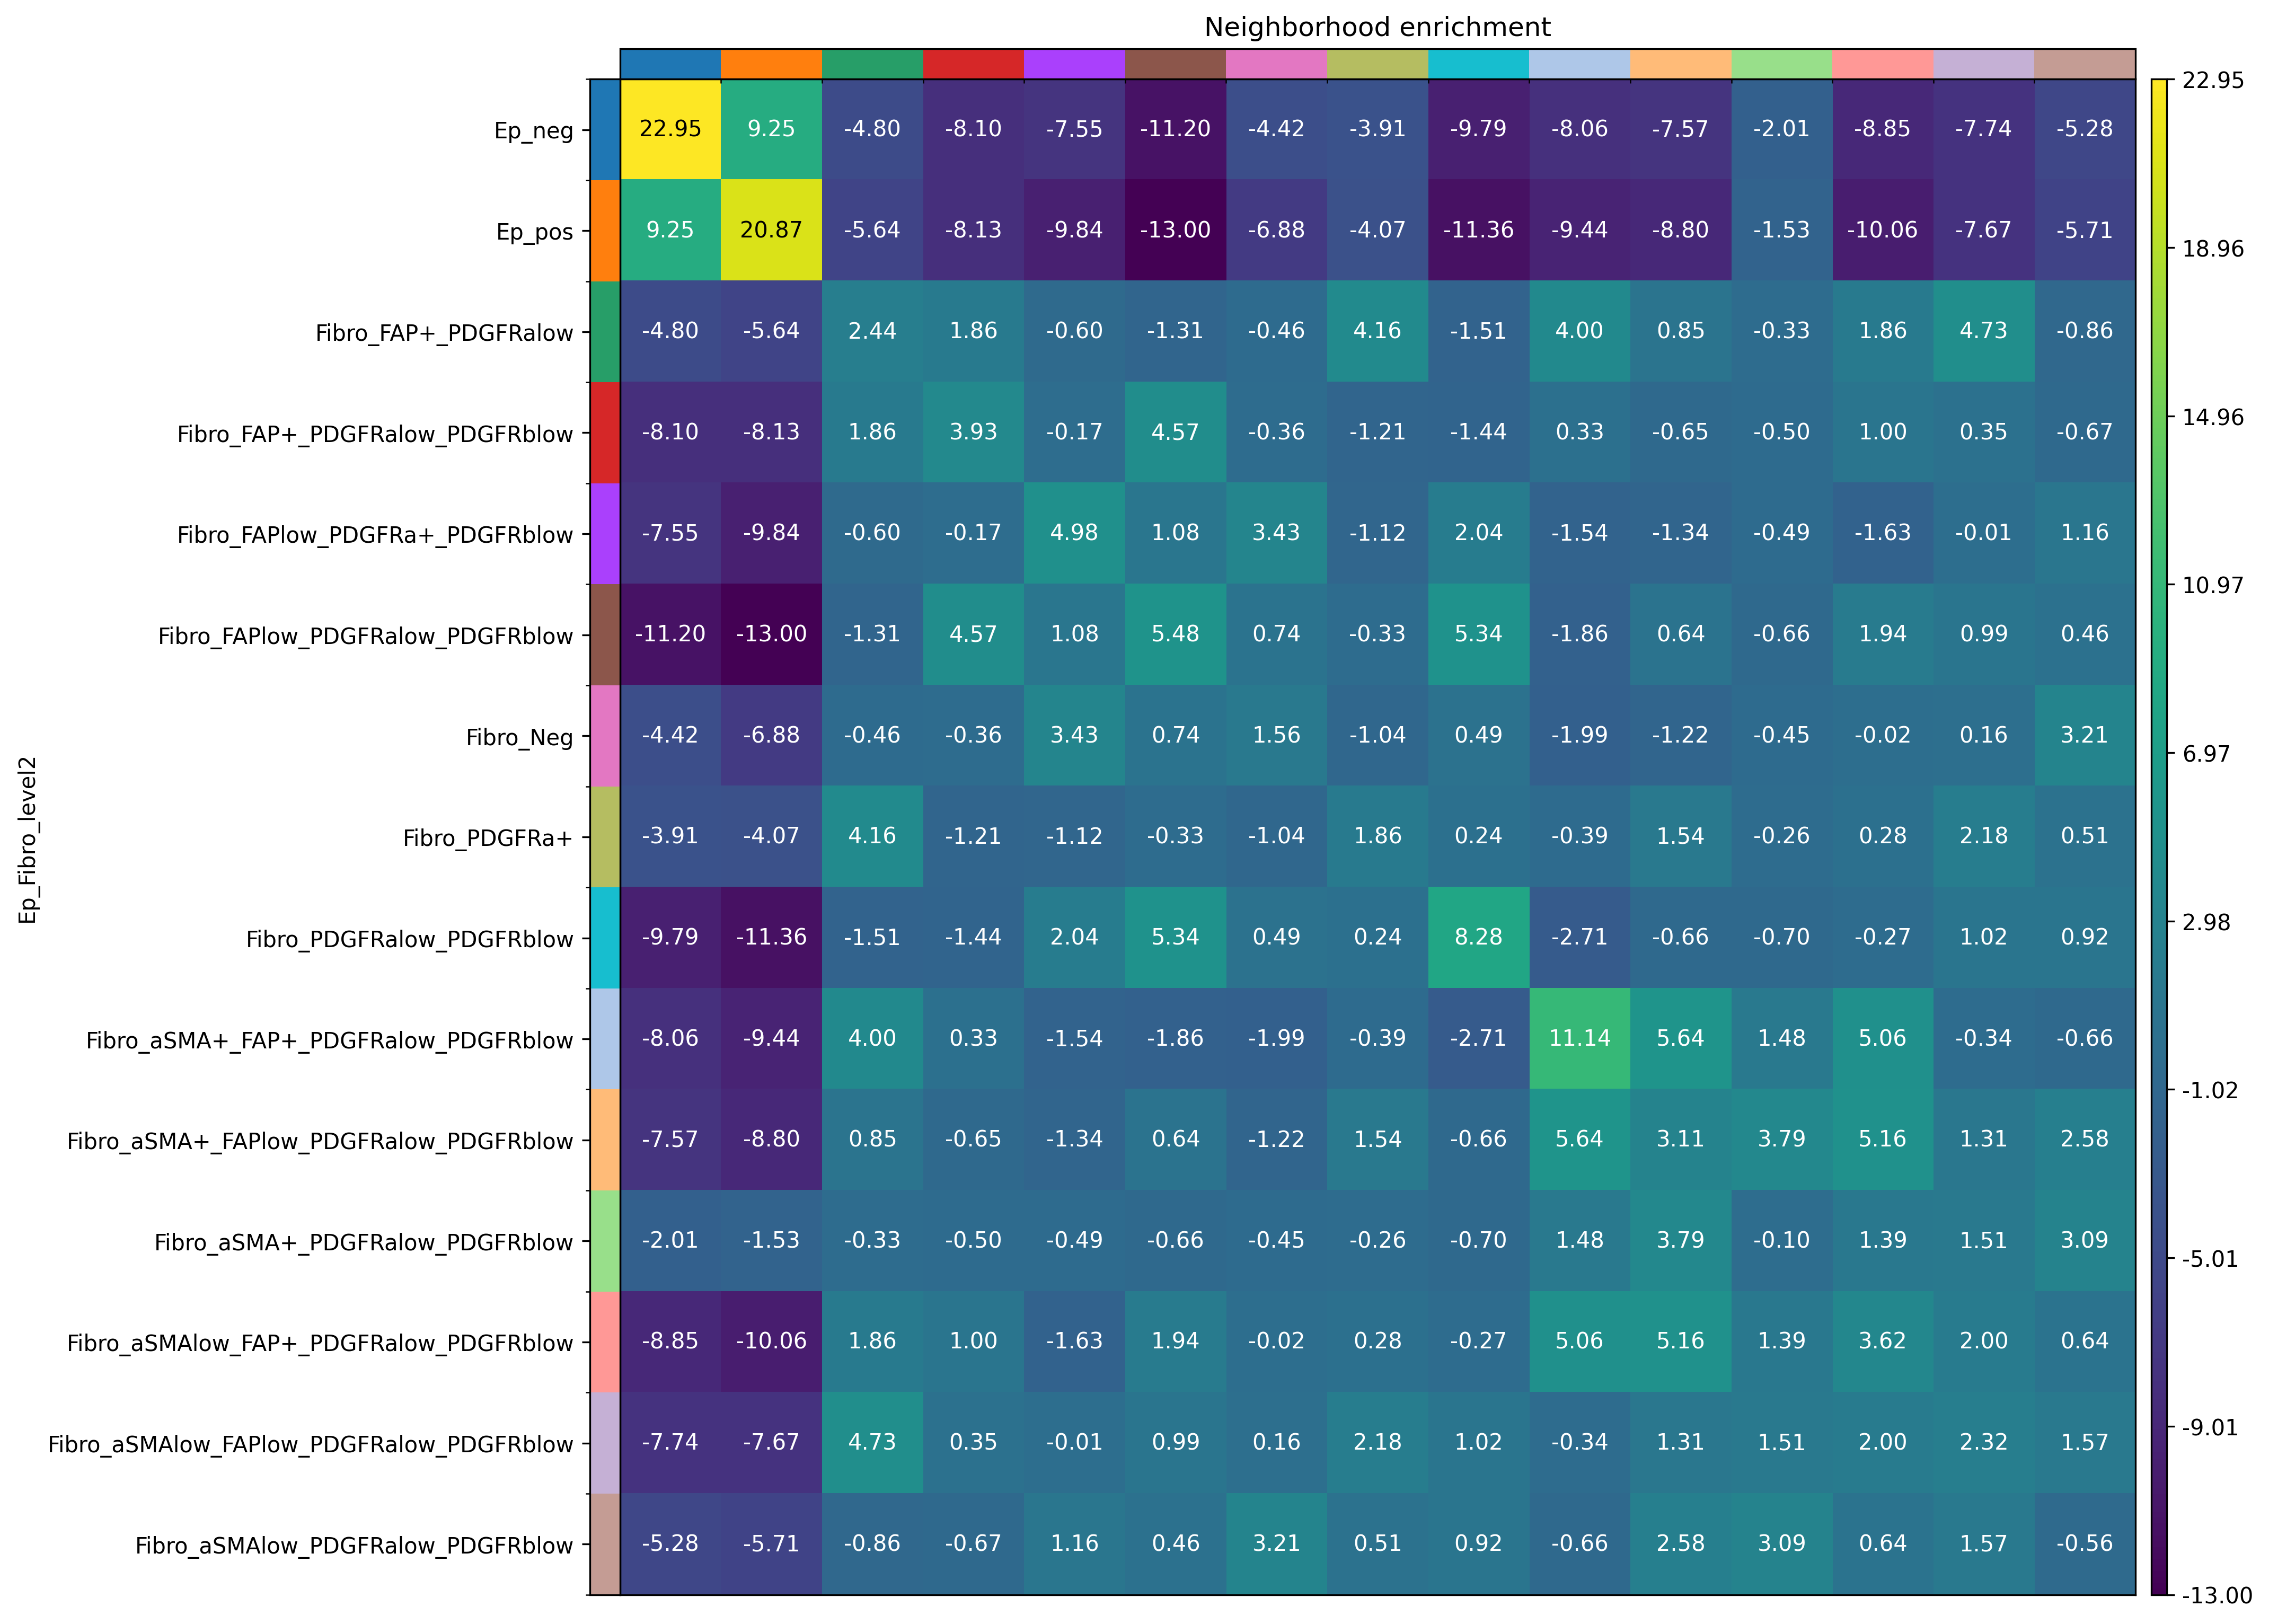

<Figure size 800x500 with 0 Axes>

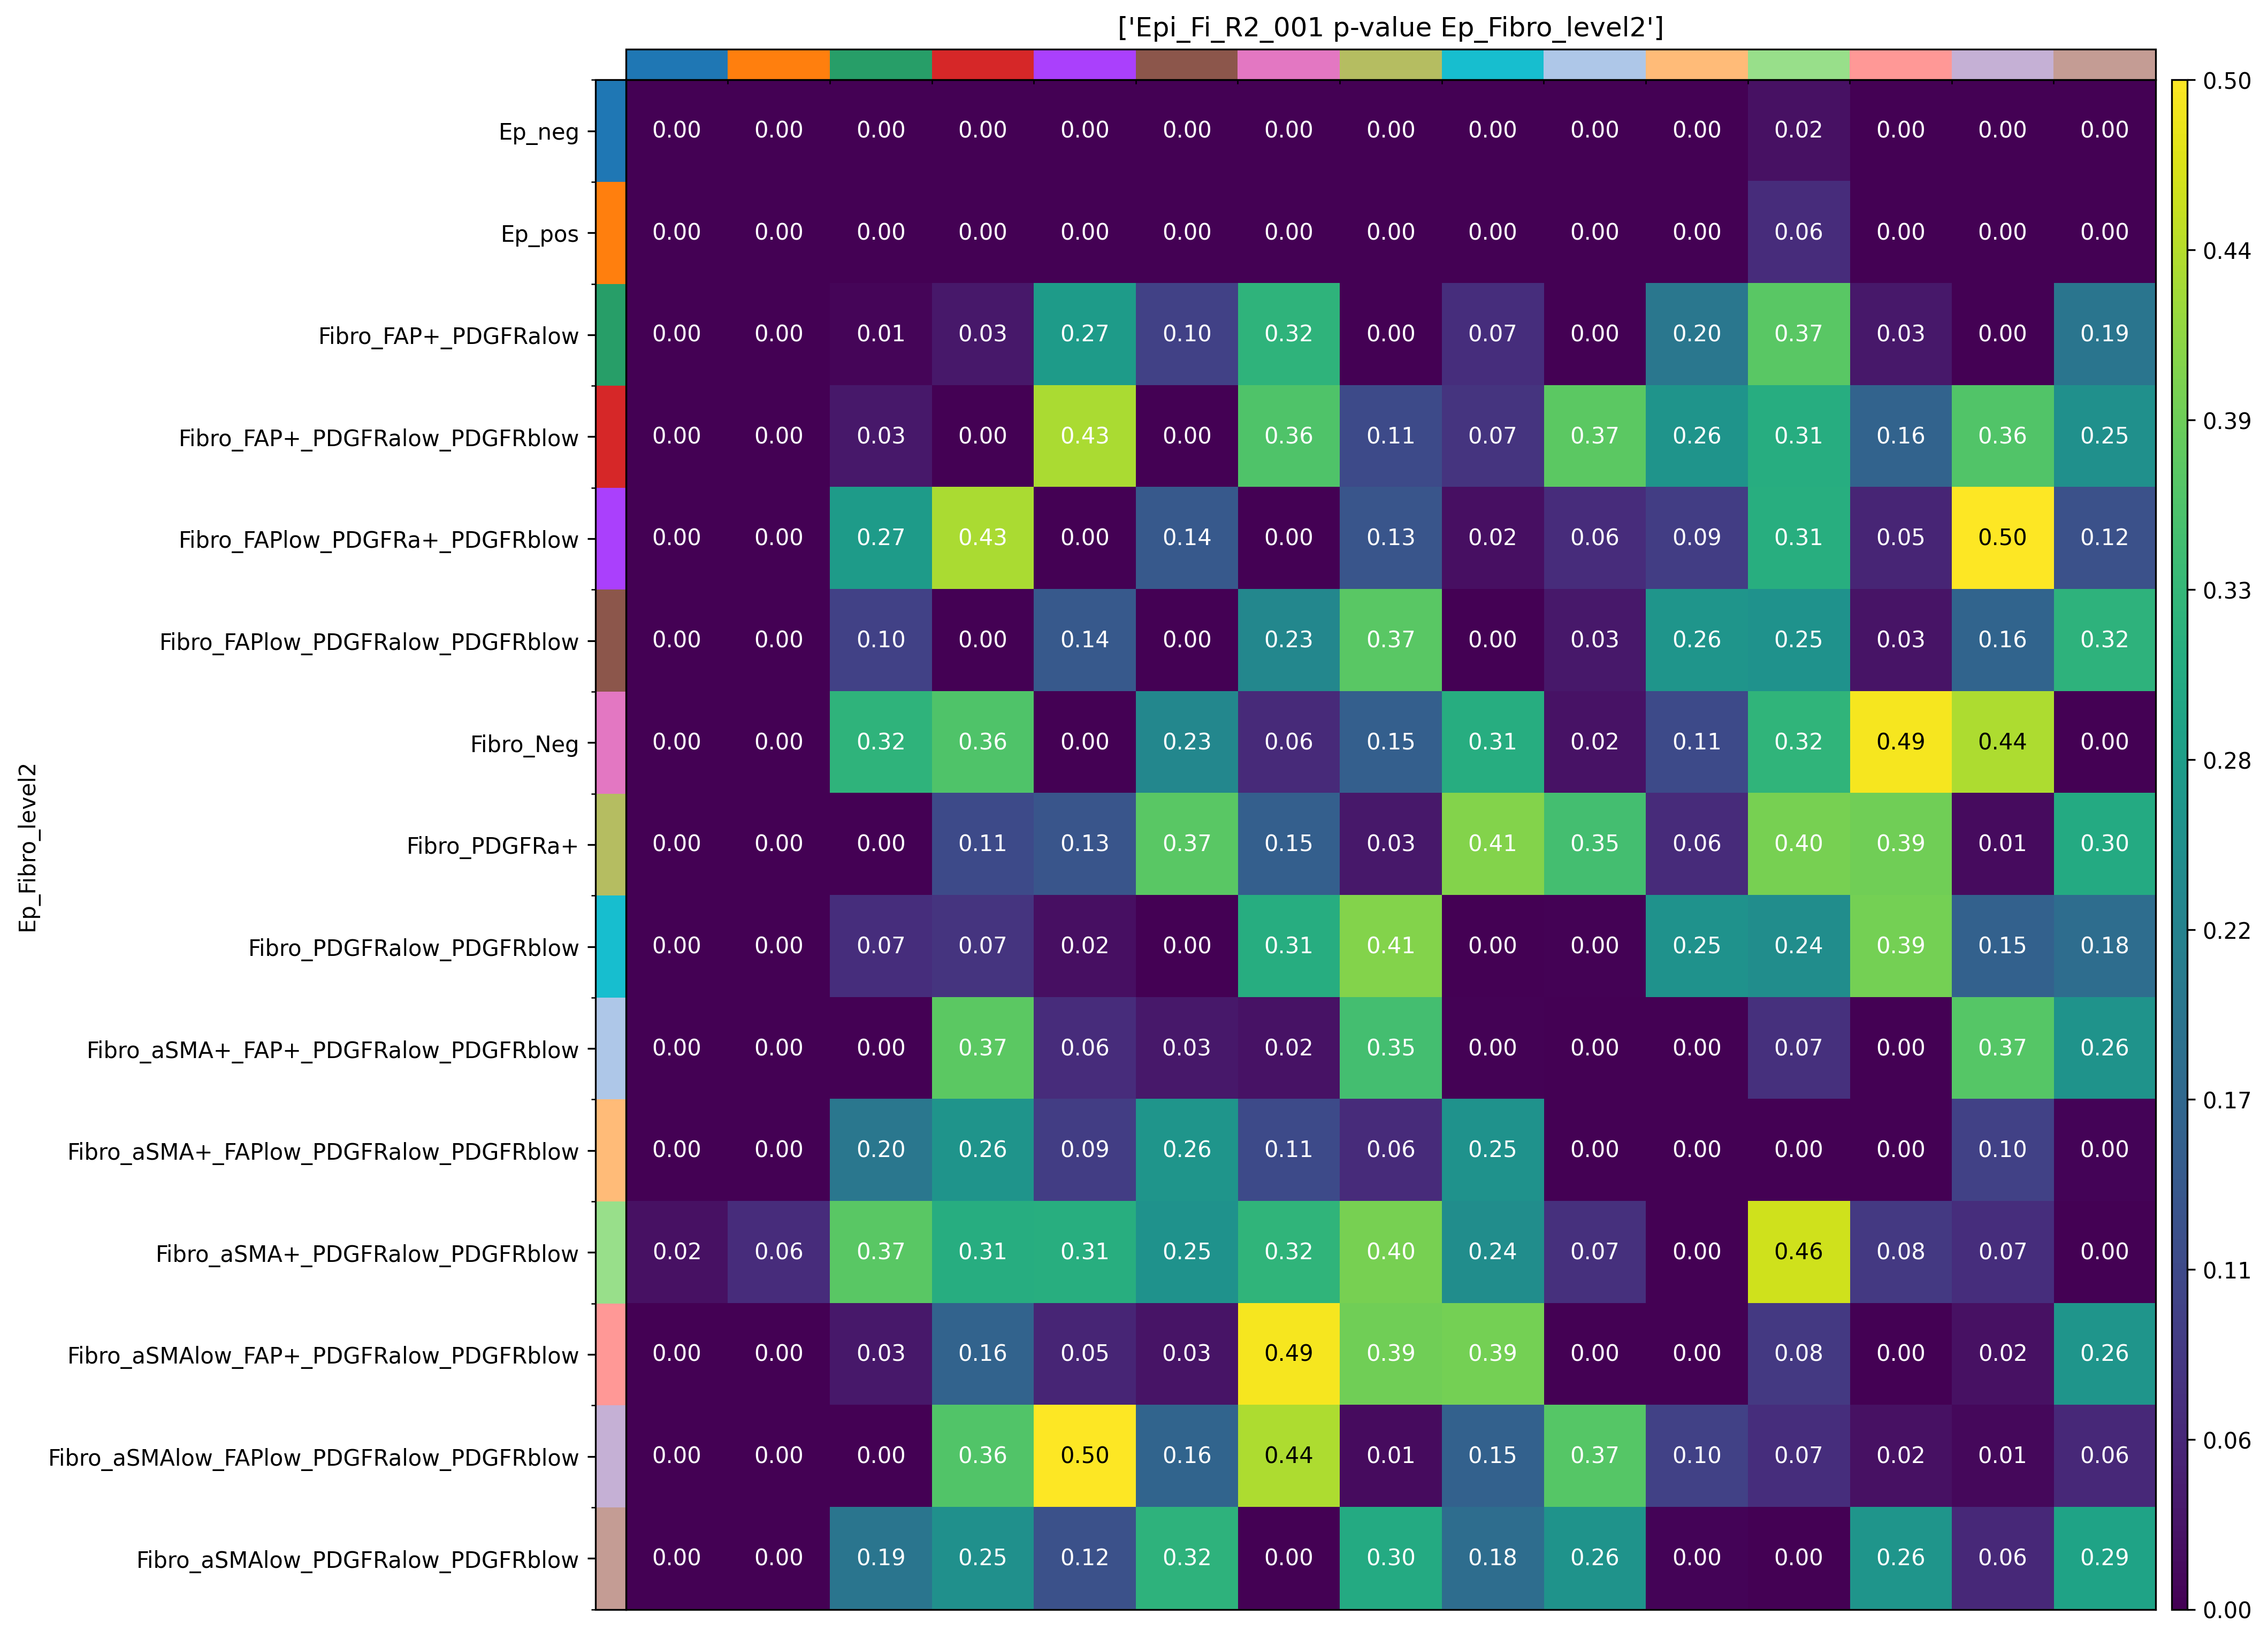

<Figure size 800x500 with 0 Axes>

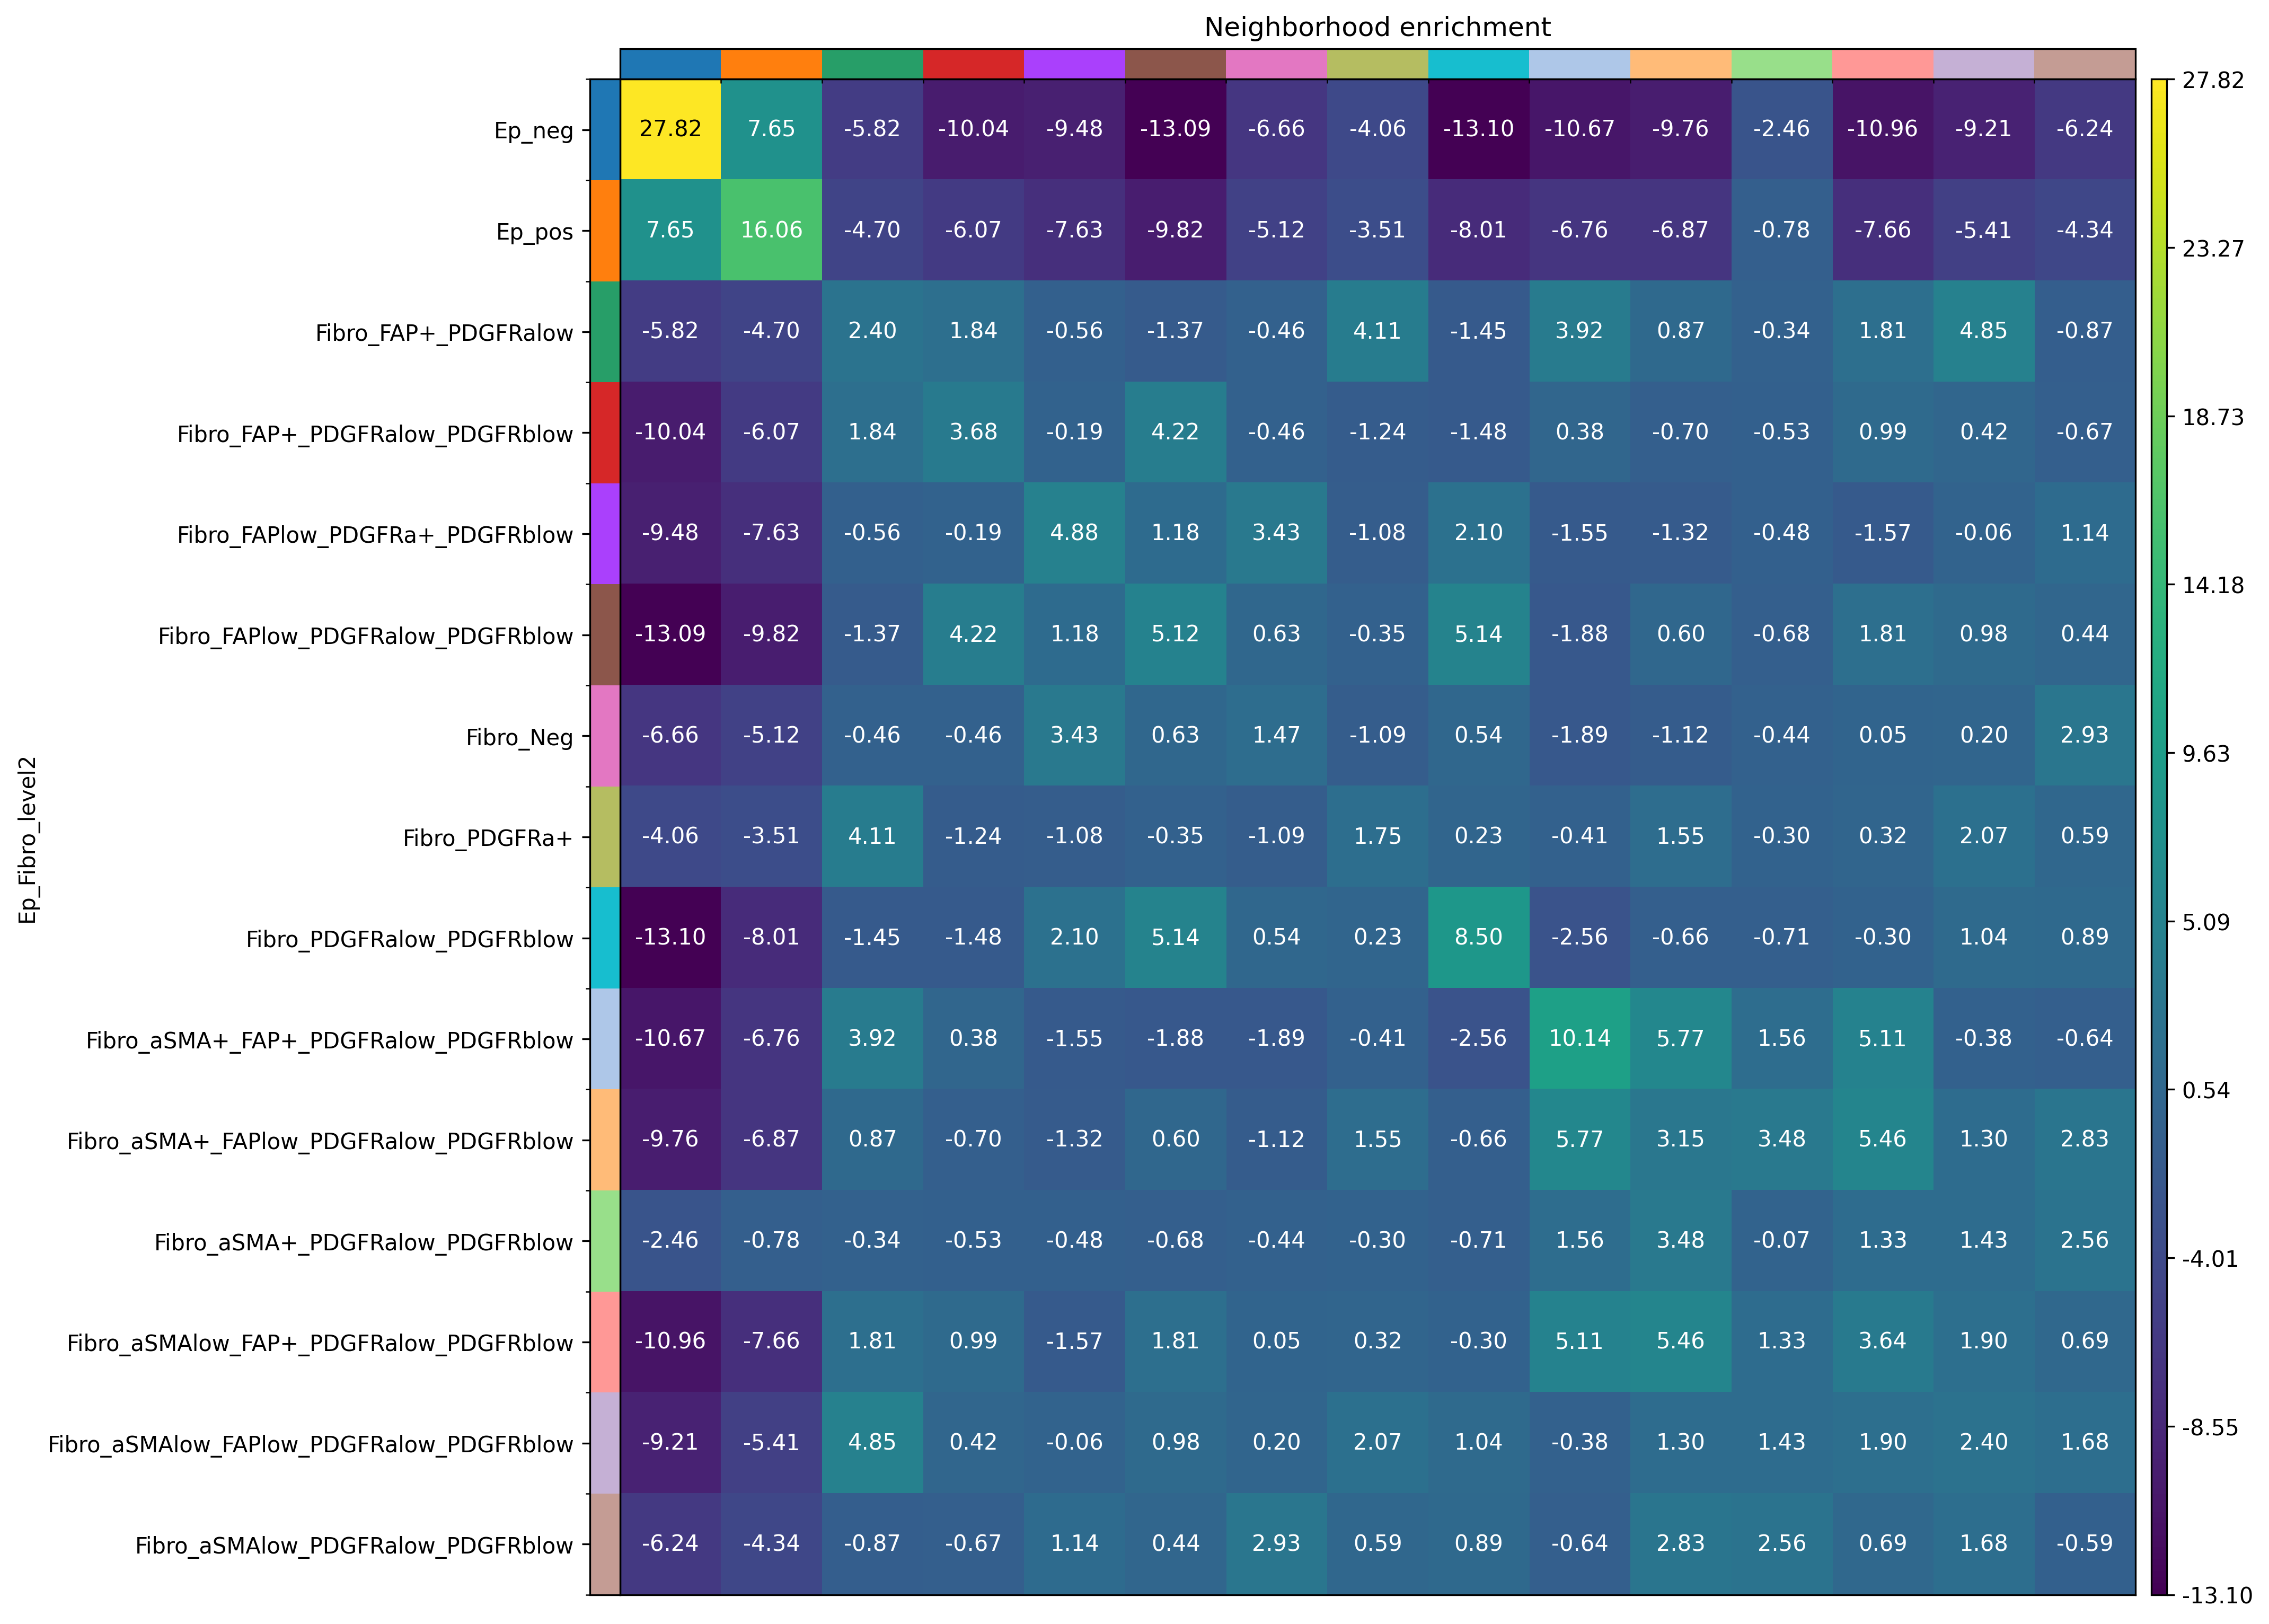

<Figure size 800x500 with 0 Axes>

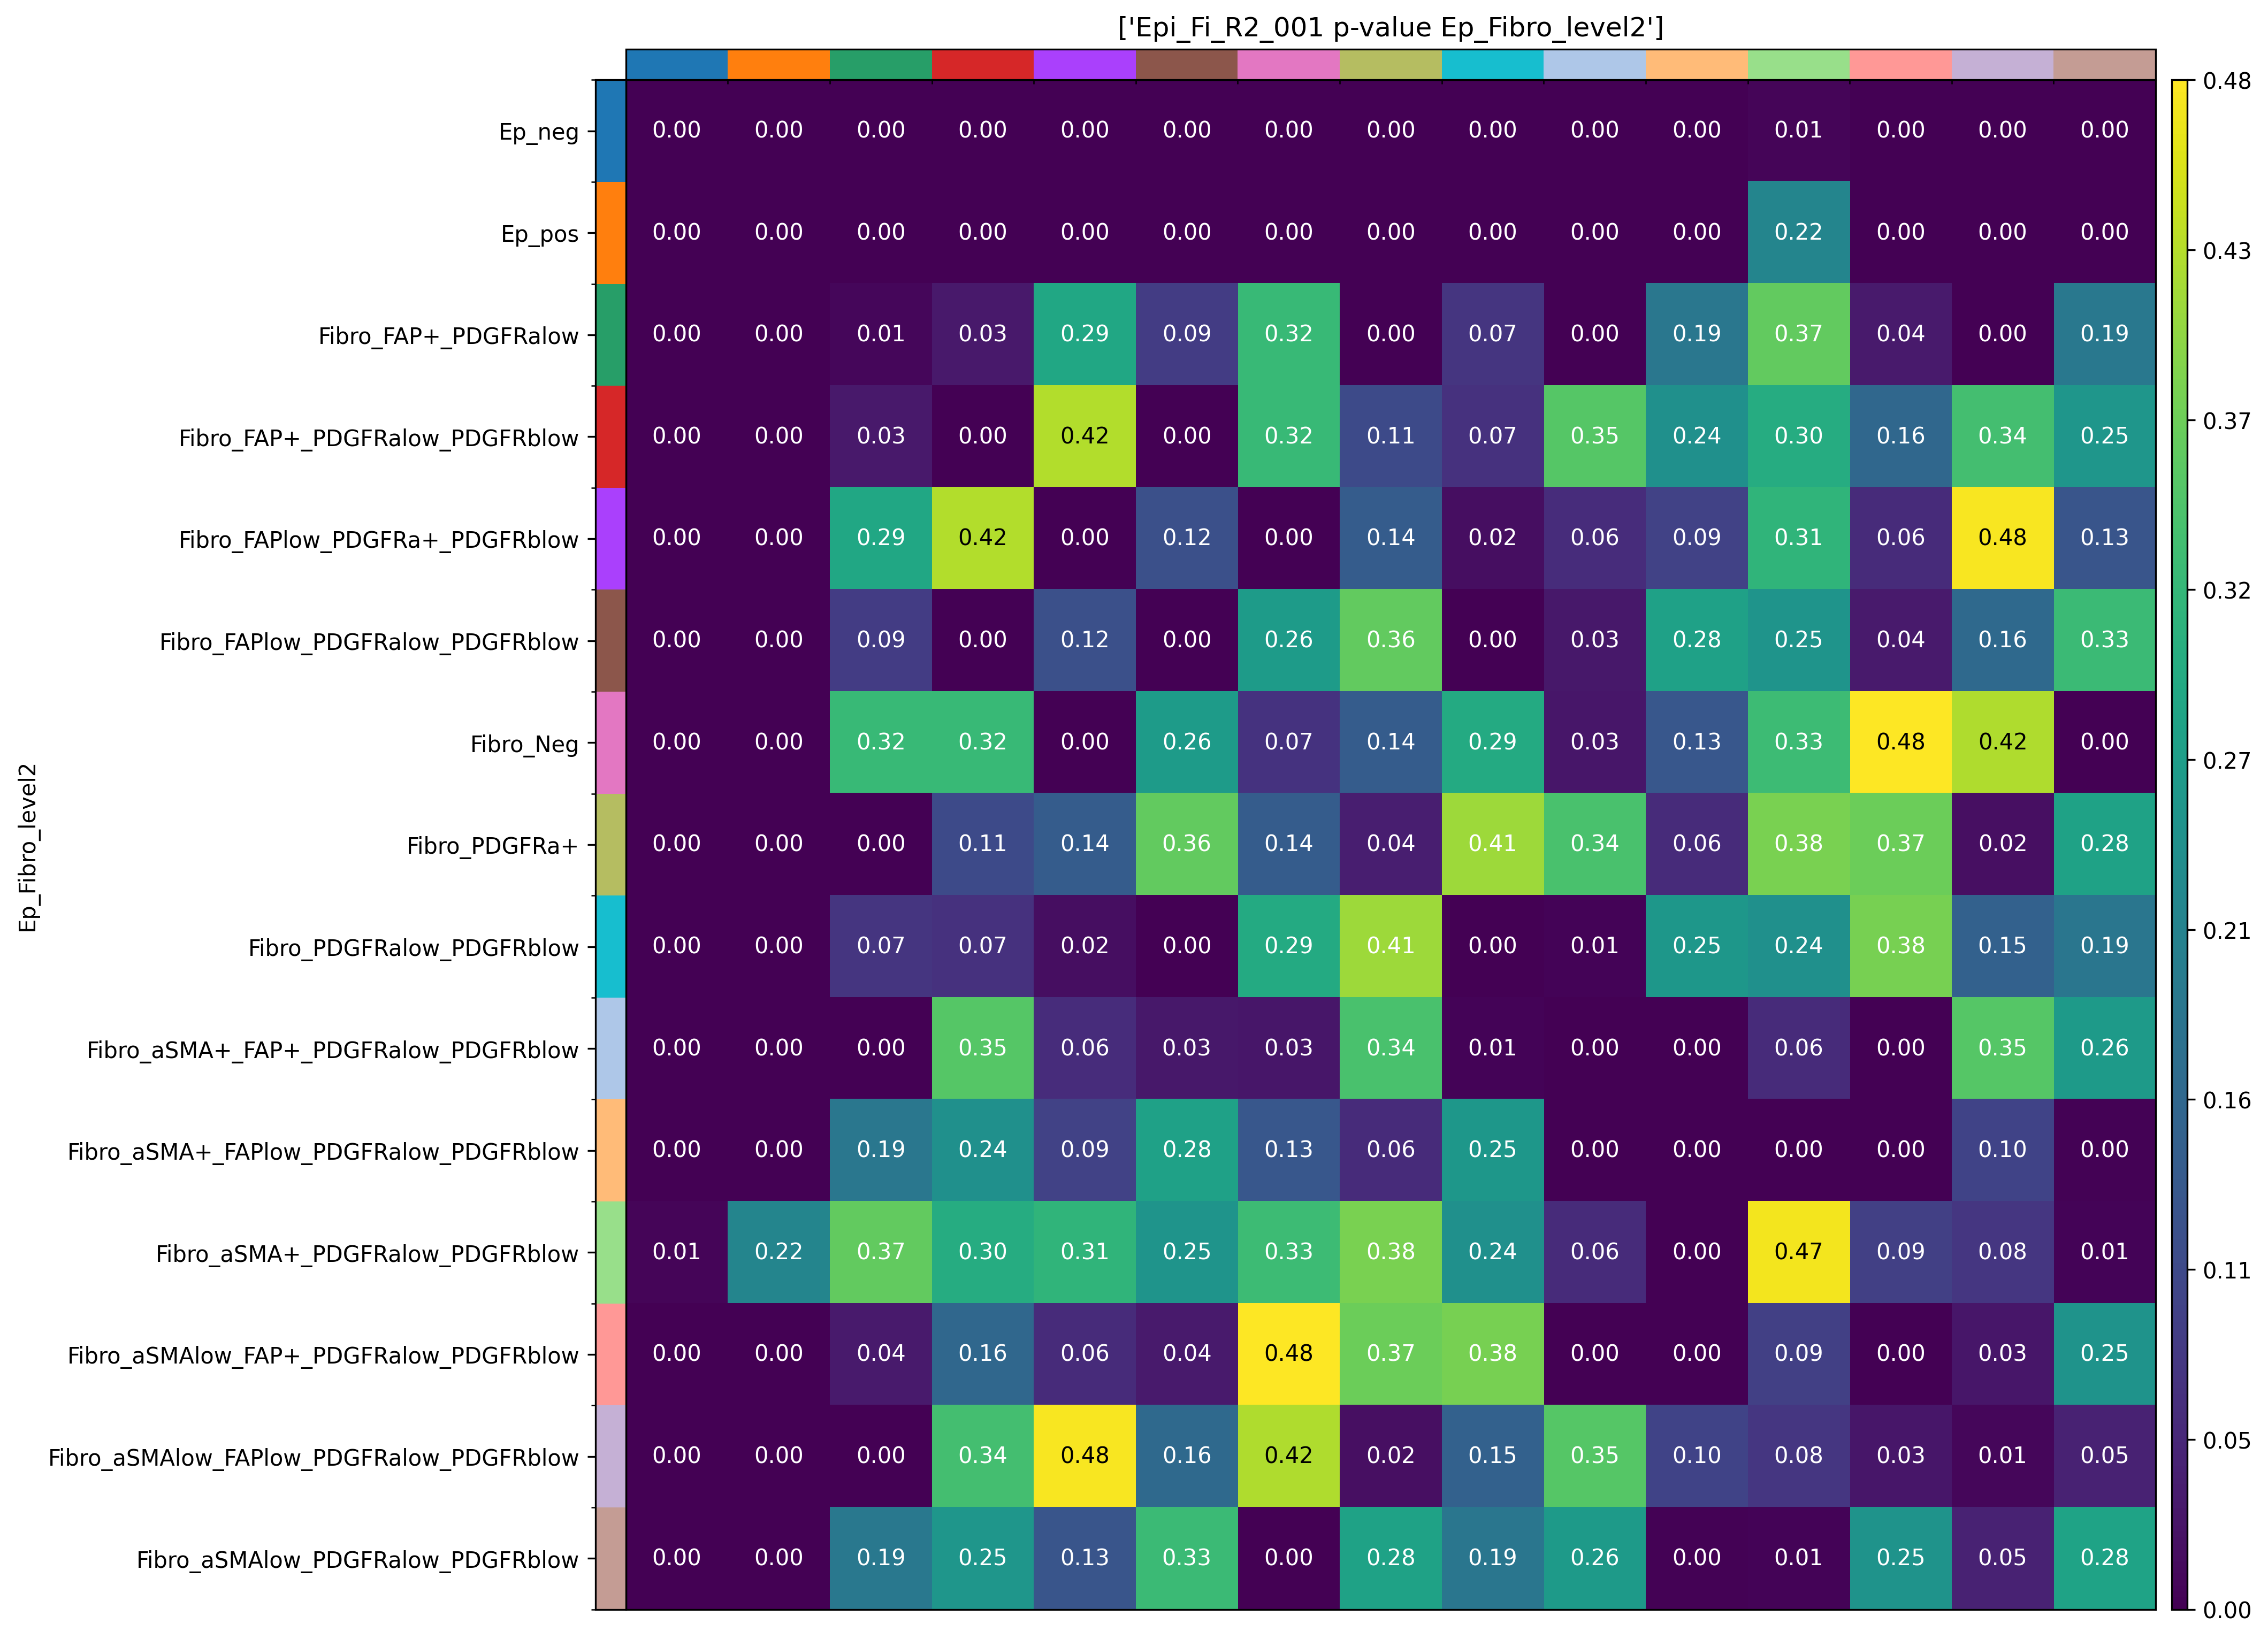

<Figure size 800x500 with 0 Axes>

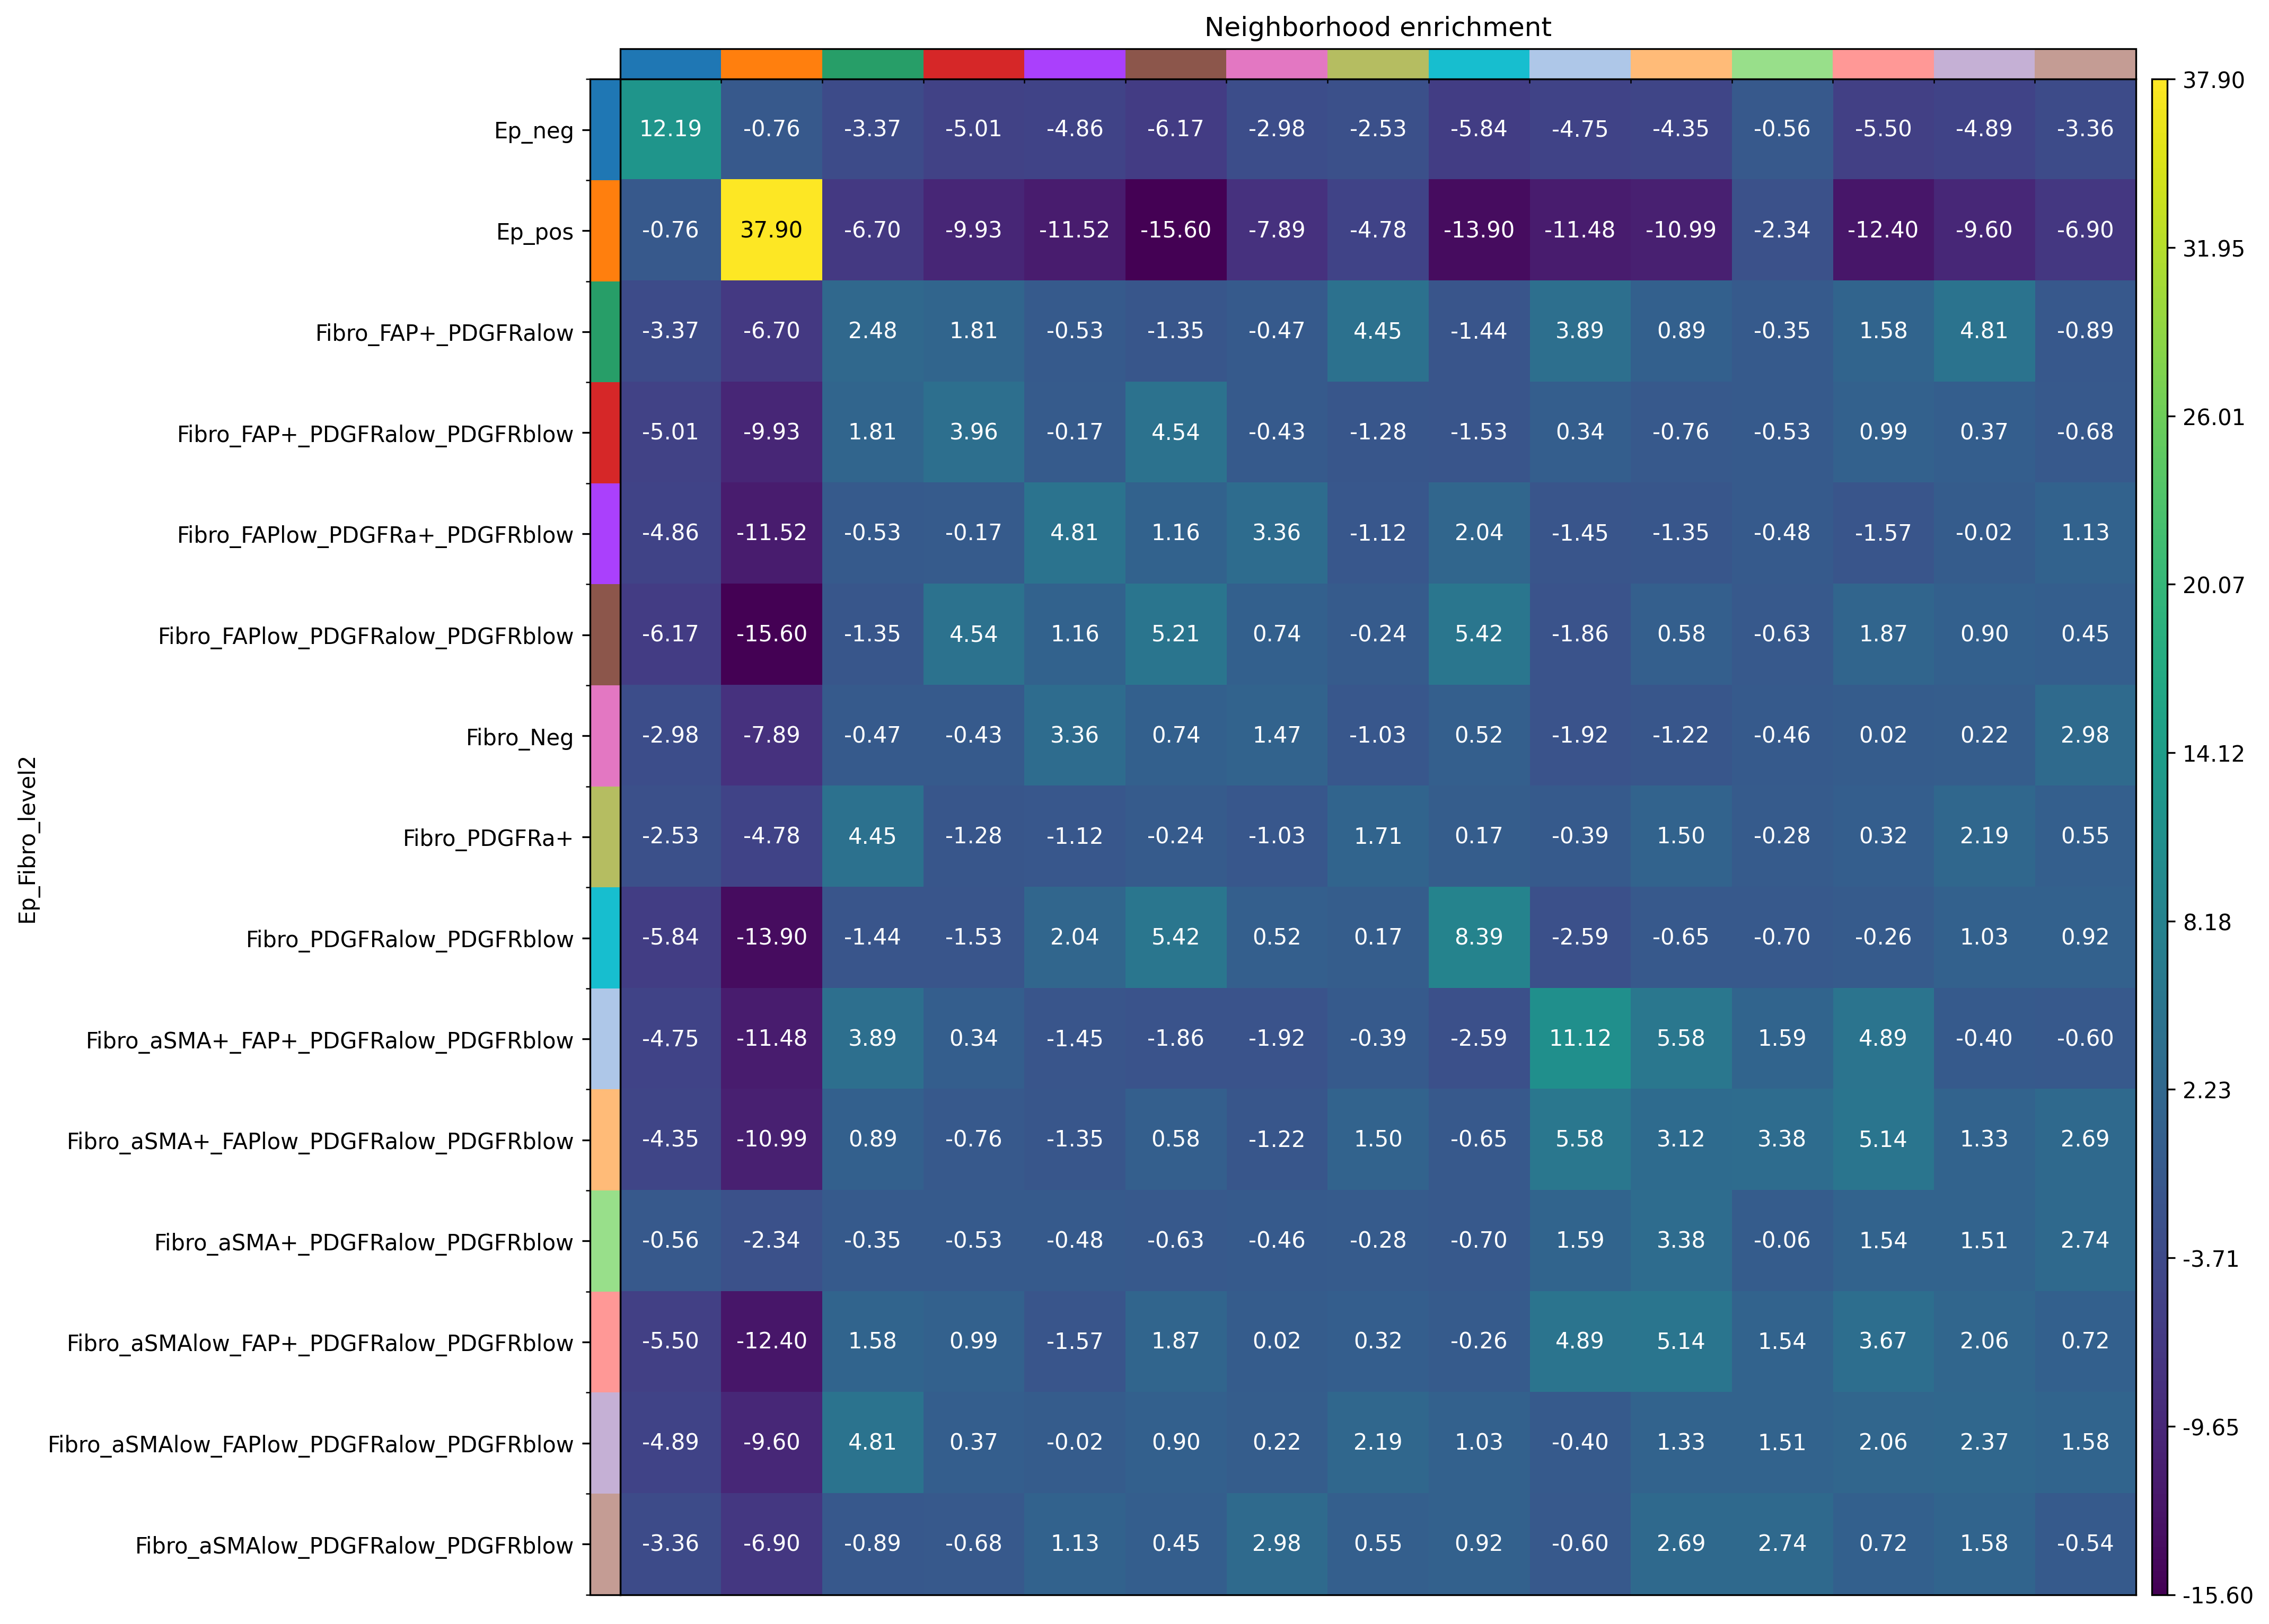

<Figure size 800x500 with 0 Axes>

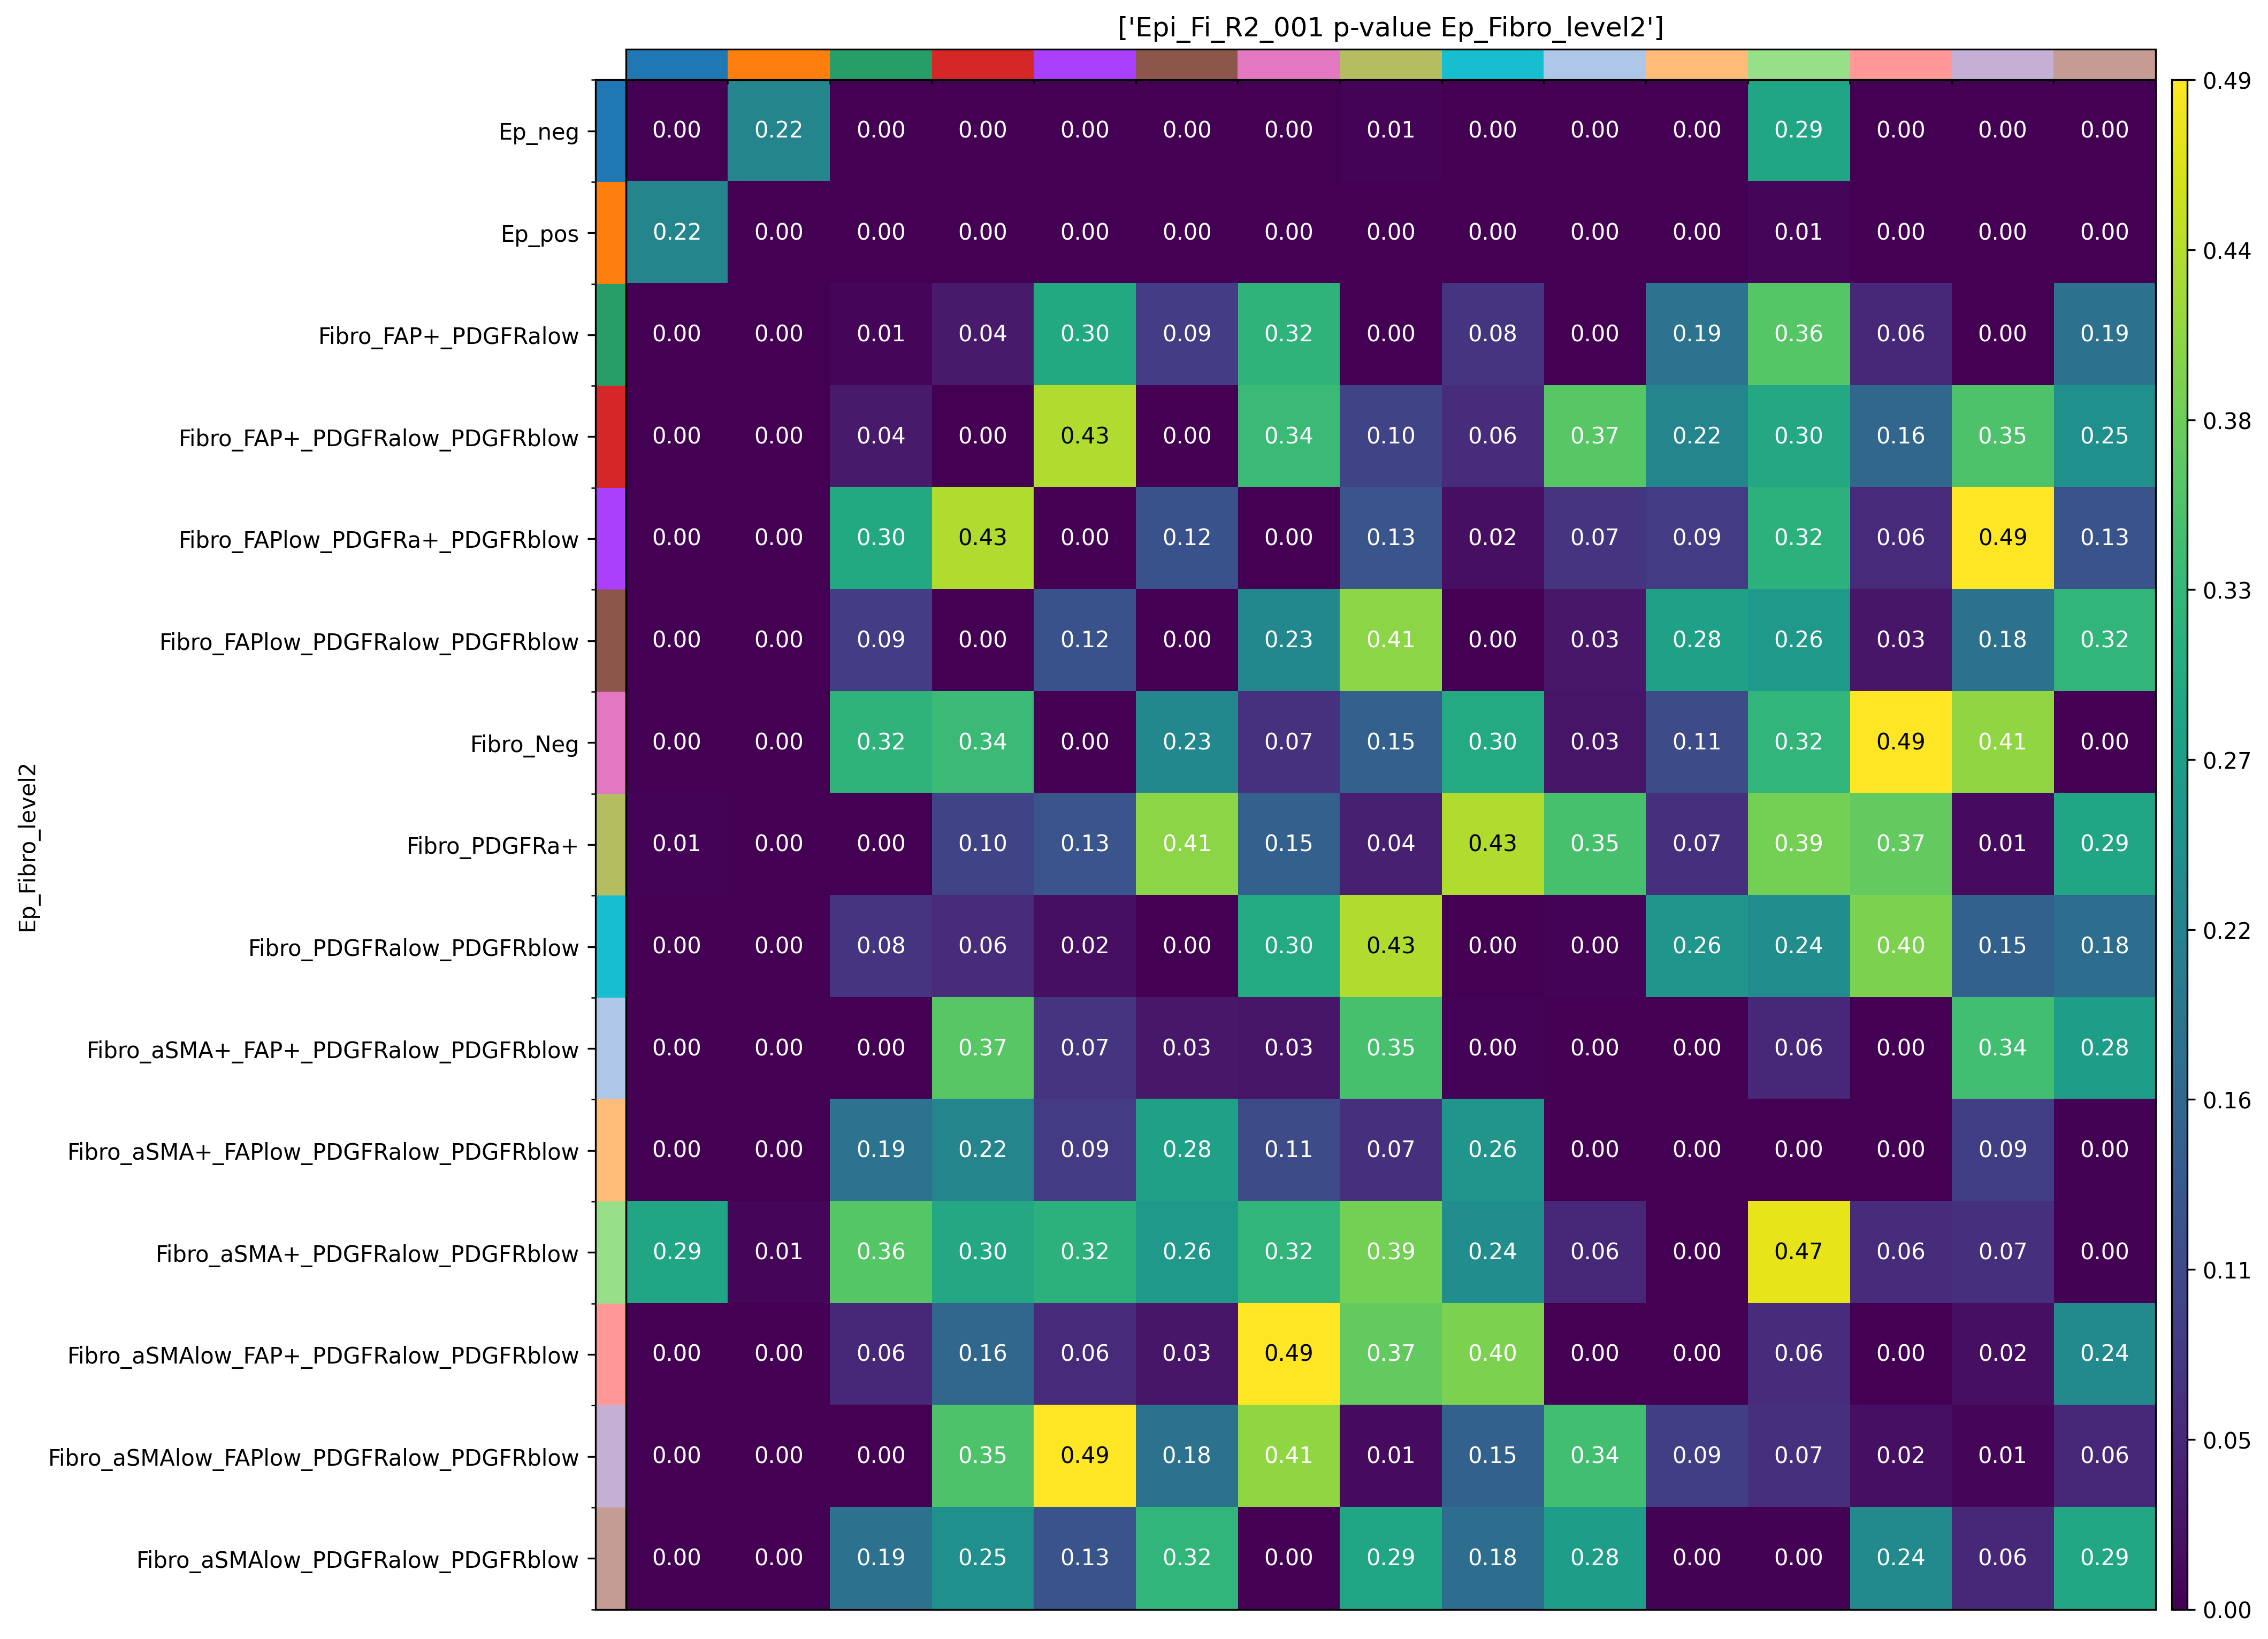

In [12]:
radius = 15

for key in marker_threshold_dict.keys():
    print(key)
    cols = Epi_adata.obs.columns[Epi_adata.obs.columns.str.contains(key)]
    for col in cols:
        # 1. merge adata for epi and fibro
        merge_adata = ut.merge_adata(Epi_adata, Fibro_adata,
                                     merge_obs1=col,
                                    merge_obs2='Fibro_level2_annotated',
                                    merge_obs_name='Ep_Fibro_level2')  
        # 2. run spatial analysis
        sa.run_spatial_nhood(merge_adata, 'Ep_Fibro_level2', radius =radius)

        # 3. create output dir if not exist
        output_path = output_dir+ '/'+col
        if not os.path.exists(output_path):
            os.makedirs(output_path)
            print(f"{output_path} created successfully!")
        # 4. save adata for each pair
        ut.save_pickle_obj(
            output_path+ '/Epi_Fi_spatial_'+
            col+'_'+myimg_id+'.pkl', merge_adata)
        # 5. plot spatial analysis
        sa.plt_spatial_nhood(merge_adata, 'Ep_Fibro_level2', col, 'Epi_Fi_'+myimg_id)
        sa.plt_spatial_pval(merge_adata, 'Ep_Fibro_level2', col, 'Epi_Fi_'+myimg_id)
        
                                  
        print(col)